In [4]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
%pip install torch torchvision
import torch


Note: you may need to restart the kernel to use updated packages.


In [ ]:
def f(x):
    return 3*x**2 -4*x + 5

In [ ]:
f(3.0)

In [ ]:
xs = np.arange(-5, 5, .25)
ys = f(xs)
ys
plt.plot(xs, ys)

In [ ]:
h = 0.001
x = 3.0
(f(x+h) - f(x))/h

In [ ]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

In [ ]:
h = 0.0001

a = 2.0
b = -3.0
c = 10.0
d1 = a*b + c
a += h
d2 = a*b + c 
print('d1', d1)
print('d2', d2)
print('slope', (d2-d1)/h)

In the below block, we define our Value object:
def __init__ declares the object and instantiates the variables
__repr__ is a wrapper that returns a value string rather than a hex representation of the memory address
__add__ and __mult__ permit addition and multiplication functionality
_children() - is the child nodes that were used to create the object e.g. if a = x + y, x and y are the children of a
_op defines the operator used to create the value from the children i.e. multiplication addition subtraction etc 

We use tanh as the activation function which is a hyperbolic function. The reason we use it is to constrain output and cap it to 1. So if we feed a large positive number as input, it will converge towards 1. 

![tanh](./img/tanh.png)

1**x
self.data**x 


In [9]:
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out
  
  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward():
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward
    
    return out
  
  
  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [95]:
%pip install graphviz
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    dot.node(name = uid , label="{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad ), shape='record')
    if n._op:
      dot.node(name = uid + n._op, label=n._op)
      dot.edge(uid + n._op, uid)
  for n1, n2 in edges:
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)
  return dot

Note: you may need to restart the kernel to use updated packages.


In [ ]:
draw_dot(L)

L = d * f - we need to know dL/dd
(f(x+h) - f(x))/h
((d+h)(f) -f(d))/h

((d+h)*f - d*f))/h
(df + fh -df)/h
fh/h = f

therefore the derivative of f is d 

dL 

In [ ]:
# Manual back propogation
L.grad = 1.0
f.grad = 4
d.grad = -2.0

d

Now we need to find out  Derivative dL / dc

What is derivative of dd/dc

dd/dc = 1.0
dd/de = 1.0

d = c + e

(f(x+h) - f(x))/h

(f(c + h +e ) - (c + e))/ h
h/h = 1


We are trying to find derivate of L with respect to e, where e is a derivative of f and d
Now we use the chainrule - https://en.wikipedia.org/wiki/Chain_rule


Want:
 dL/dc

know:
dd/dc and dL/dd

by chainrule
dL/dc = dd/dc * dL/dd
dL/de = 1 * (-2)
dL/de = -2.0


In [ ]:
c.grad = -2.0
e.grad = -2.0

Now lets get the remaining two:

dL/de = -2.0

dL/db and dL/da

dL/da = dL/de * de/da

we know e = a*b
from previous we know de/da  = b as a*b(a will always change by b) and b = 3

therefore de / da = 3

so dL/da = -2 * -3 =6

In [ ]:
a.grad = -2.0*-3.0

simalrily for
dL/de=-2.0
dL / db = dL/de * de/db

de/db = 2 as e = a*b therefore change of b to e is equal to the value of a

therefore
dL/db = -2.0 * 2.0 = -4.0


In [ ]:
b.grad = -2.0*2.0

In [ ]:
#Test it out

a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a*b
d = e + c
L = d * f
print(L.data)

Backpropogate through a neuron

In [ ]:
# Squashing function, we multiply the activation function by the product where the neuron is the sum of the inputs multiplied by the weights and the bias
plt.plot((np.arange(-5,5,0.2)), np.tanh(np.arange(-5,5,0.2))); plt.grid() 

In [ ]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# Weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1w2 + x2w2 + bias
x1w1x2w2 = x1w1 +x2w2 ; x1w1x2w2.label = 'x1w1x2w2'
n = x1w1x2w2 + b; n.label = 'n'

o = n.tanh(); o.label = 'o'
o.backward()



In [ ]:
o.grad = 1.0
draw_dot(o)

In [ ]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# Weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1w2 + x2w2 + bias
x1w1x2w2 = x1w1 +x2w2 ; x1w1x2w2.label = 'x1w1x2w2'
n = x1w1x2w2 + b; n.label = 'n'

#-----------------#
e = (2*n).exp() ; e.label = 'e'
o = (e-1)/(e+1) ; o.label = 'o'
#-----------------#

o.backward()
draw_dot(o)



Now lets find the derivitive of do/dn  but which has an operator of tanh
- therefore do/dn = 1 - tanh(n)^2
do/dn = 1 - tanh(n)^2
do/dn = 1 - tanh(0.8814)^2


In [ ]:
# do/dn = 1 - tanh(n)**2
# but we know tanh = 0 
# Therefore  do/dn = 1 - o**2

n.grad = 1 - o.data**2
x1w1x2w2.grad = 0.5 # as its a plus node to n so grad remains the same
b.grad = 0.5  # as its a plus node to n so grad remains the same
x1w1.grad = 0.5 # as its a plus node to n so grad remains the same
x2w2.grad = 0.5 # as its a plus node to n so grad remains the same


### here comes the chain rule
x1.grad = w1.data * x1w1.grad # as its a mul node to x1w1 so grad is w1 - simple multiplication
w1.grad = x1.data * x1w1.grad # as its a mul node to x1w1 so grad is x1 - simple multiplication
x2.grad = w2.data * x2w2.grad # as its a mul node to x2w2 so grad is w2 - simple multiplication
w2.grad = x2.data * x2w2.grad # as its a mul node to x2w2 so grad is x2 - simple multiplication

Here's the automated way with our backward functions, does the above steps automatically. Look at how we have added backward function to our object

In [ ]:
o.grad = 1.0
o._backward()
n._backward()
b._backward()
x1w1x2w2._backward()
x2w2._backward()
x1w1._backward()

Topological sort
Builds the graph so we can go through and fill in grad in correct order

This does all the grads for us

In [ ]:
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
      visited.add(v)
      for child in v._prev:
        build_topo(child)
      topo.append(v)
build_topo(o)
topo

We now reverse the topo set, as we want to work from end value o (0.70701)

In [ ]:


for node in  reversed(topo):
    node._backward()

We then move this up to our class defintion and can call it here (see def backward() in value Class)

In [ ]:
o.backward()

Now we need to fix a bug. Here is the bug below

In [ ]:
a = Value(3.0, label='a')
b = a + a ; b.label = 'b'
b.backward()
draw_dot(b)

The grad is actually 2 as db/da = (2(a+h) - 2a)/ (h) = 2h/h = 2

What is happening is we are overwriting the gradient (i.e. 1 being overwritteen by 1, when they really should be added due to the multivariable chain rule). Another example is shown below

In [ ]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')

d = a*b; d.label = 'd'
e = a + b; e.label = 'e'
f = d * e ; f.label = 'f'
f.backward()
draw_dot(f)

The above results in the gradient of a and b being incorrect. If we use a variable more than once, it causes issues. When we call backward from e and d, d will overwrite e's gradients as it is using the same variables

Now we need to use multivariable rule in the chain rule - to this, in our class where we define backward, we need to '+=' to factor in multiple cases of the same variable being used. 
''
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
''



Now lets use an pytorch to automate this

In [10]:
import torch

x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())


0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [152]:
import random

class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
    def __call__(self, x):
     act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
     out = act.tanh()
     return out

    def parameters(self):
       return self.w + [self.b]

class Layer:
   def __init__(self, nin, nout):
       self.neurons = [Neuron(nin) for _ in range(nout)]
    
   def __call__(self, x):
    outs = [n(x) for n in self.neurons]    
    return outs[0] if len(outs) == 1 else outs
   
   def parameters(self):
    params = []
    for neuron in self.neurons:
        parameters = neuron.parameters()
        params.extend(parameters)
    return params


class MLP:
    def __init__(self, nin, nouts):
      sz = [nin] + nouts
      self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    
    def __call__(self, x):
      for layer in self.layers:
        x = layer(x)
      return x
    
    def parameters(self):
       params = []
       for layer in self.layers:
            parameters = layer.parameters()
            params.extend(parameters)
       return params



Value(data=0.10995149842010848)

In [153]:
x = [2.0,3.0, -1]
n = MLP(3,[4,4,1])
n(x)

Value(data=-0.041840248621943486)

In [154]:
n.parameters()

[Value(data=-0.2813507603311751),
 Value(data=0.21756347522192332),
 Value(data=-0.3929832427206279),
 Value(data=0.5823177859318489),
 Value(data=0.3360280281236323),
 Value(data=0.19882990282443158),
 Value(data=-0.8584314994165079),
 Value(data=0.101432977846029),
 Value(data=-0.7703259712610746),
 Value(data=0.4289702846216903),
 Value(data=0.12390396740927434),
 Value(data=-0.7836208508908877),
 Value(data=-0.3601732570540077),
 Value(data=0.3939392766031238),
 Value(data=0.7430595030085276),
 Value(data=0.8346274293374316),
 Value(data=0.7250124572591321),
 Value(data=0.9106282389227085),
 Value(data=0.33414338386604925),
 Value(data=-0.6896381340687383),
 Value(data=-0.47237115612479785),
 Value(data=-0.7912712325355553),
 Value(data=-0.6536053232440382),
 Value(data=-0.8821555083172583),
 Value(data=-0.6708659576243488),
 Value(data=0.015636975110006723),
 Value(data=-0.20813205202095952),
 Value(data=0.8165921172912007),
 Value(data=0.47425158165319625),
 Value(data=-0.0474287

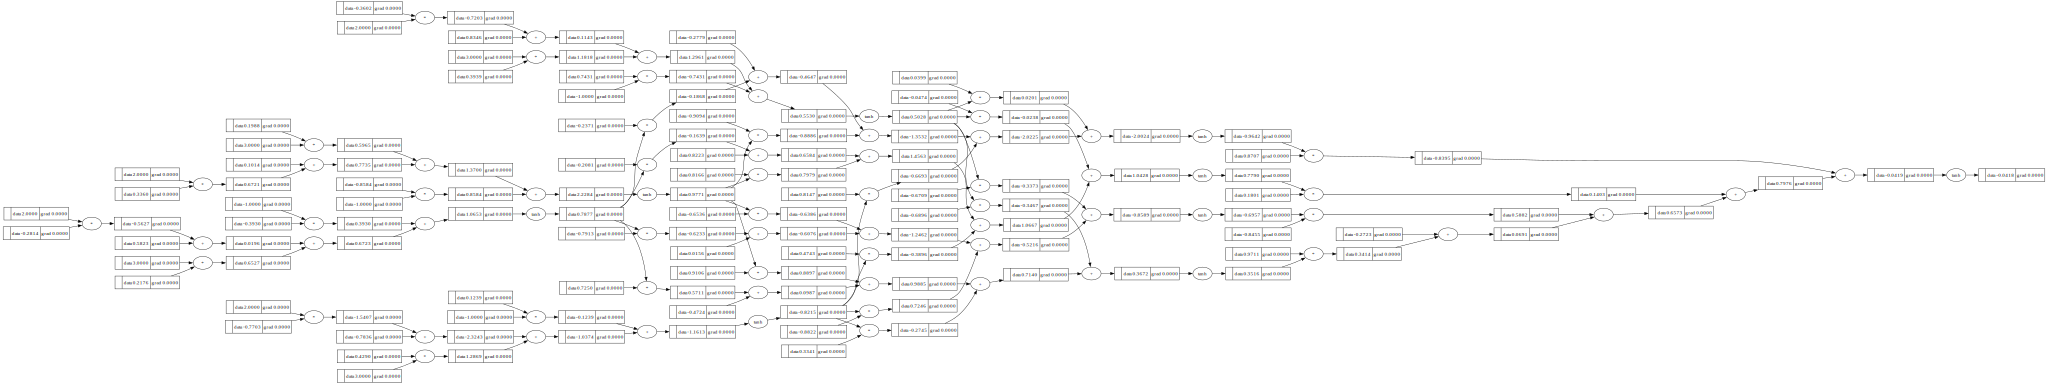

In [155]:
draw_dot(n(x))

Now lets work through an example

xs are our inputs

ys are the results we want

e.g. row 1 [2.0, 3.0, -1.0], should return 1.0

In [156]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

ypred = [n(x) for x in xs]
print(ypred)

[Value(data=-0.041840248621943486), Value(data=-0.9747844846306812), Value(data=-0.8788773785048742), Value(data=-0.13929547810777088)]


Calculate the loss function to see how off it currently is

In [157]:
[(yout - ygt)**2 for ygt, yout in zip(ys, ypred)]


[Value(data=1.0854311036486333),
 Value(data=0.0006358222153403508),
 Value(data=0.0146706894378515),
 Value(data=1.2979941864368143)]

Above we can see there is a significant amount of loss for the middle predictions (0 loss being best)

Now calculate the total loss

In [158]:
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
loss

Value(data=2.3987318017386396)

Now we can use our backward function to back propogate through the neural net and get the weights, grads, and data for each neuron. 

The MLP(A multilayer perceptron) has layers, inside layers are neurons, and each neuron has its own value and weight

In [159]:
for p in n.parameters(): # reset gradients to ensure we dont keep adding on top of them as self.grad += ...
    p.grad = 0.0
loss.backward()

Example of a weight can be seen below

In [160]:
n.layers[0].neurons[0].w[0].grad

-2.583402583743196

Get a graph of the loss function

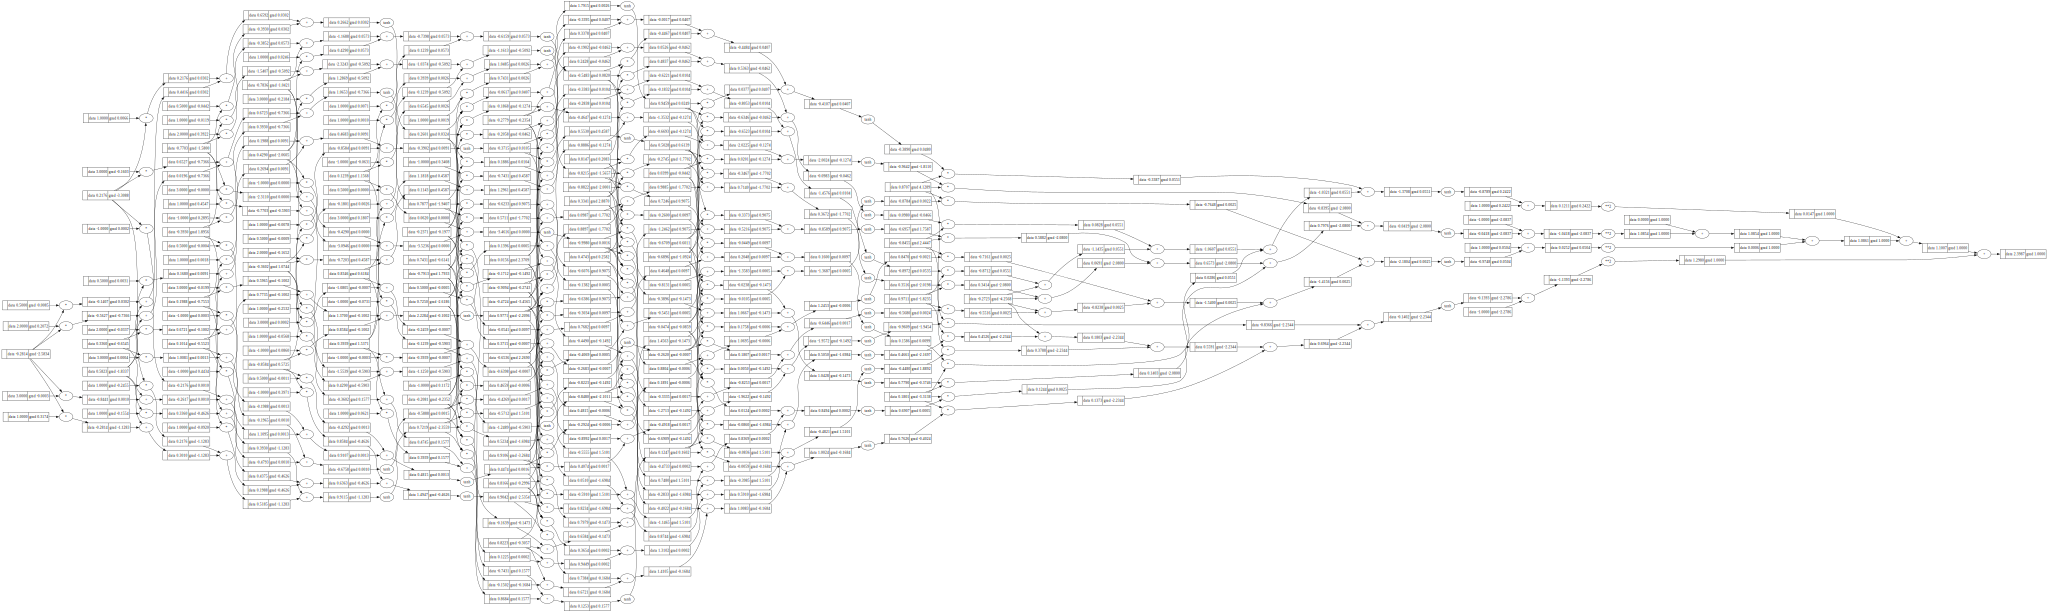

In [161]:
draw_dot(loss)

Now we iterate through the paramaters. The parameters being the weight + bias for each neuron, and we want to minimize the loss. 

So we do the following:
Forward pass 
backward pass
increase p to lower loss

We can see that our predictions are getting more accurate

i.e.

[Value(data=0.9940639237875625), out = 1
 Value(data=-0.9867327516623368), out = -1
 Value(data=-0.9650502821170667), out = -1
 Value(data=0.9923146040183972)] out =1


In [219]:
ypred = [n(x) for x in xs]
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
loss
ypred

[Value(data=0.9984903908713628),
 Value(data=-0.9964066496392768),
 Value(data=-0.99645193921903),
 Value(data=0.9981207494831433)]

In [217]:
loss.backward()

In [218]:
for p in n.parameters():
  p.data += -0.01 * p.grad

Now check our data again, and we can see that the loss has been reduced even further

In [220]:
# settings of weights and bias
n.parameters()

[Value(data=-0.3440820520702192),
 Value(data=0.6180461378551931),
 Value(data=-1.1004938093869054),
 Value(data=0.4898284677284799),
 Value(data=-0.15312104868566787),
 Value(data=0.1273606489686641),
 Value(data=-1.4088965027642775),
 Value(data=-0.2972136039230387),
 Value(data=-0.6198428942108384),
 Value(data=0.5001812285190148),
 Value(data=-0.47620313998694264),
 Value(data=-0.9184862297416706),
 Value(data=-0.456510315312586),
 Value(data=0.09667295085331913),
 Value(data=0.84089366670228),
 Value(data=0.757376572293265),
 Value(data=1.1904653816825224),
 Value(data=1.5540703347456903),
 Value(data=-0.0031764418930729024),
 Value(data=-0.6410688666040082),
 Value(data=-0.11947201980466432),
 Value(data=-1.0583143696210404),
 Value(data=-1.2035986258685007),
 Value(data=-0.6781273425706903),
 Value(data=-0.5198844591120801),
 Value(data=-0.11766219015340523),
 Value(data=-0.206446230998215),
 Value(data=0.9366046557052043),
 Value(data=0.5079978915446598),
 Value(data=-0.1614765

Lets now create an iterative tuning loop

In [ ]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

ypred = [n(x) for x in xs]
print(ypred)


In [234]:

for k in range (20):
    # Forward pass
    ypred = [n(x) for x in xs]
    loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])

    # Backward pass
    # reset gradients to ensure we dont keep adding on top of them as self.grad += ...
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    # Update weights and bias i.e. parameters
    for p in n.parameters():
        p.data += -0.05 * p.grad
   
    print(k , loss.data)

[Value(data=1.0), Value(data=-0.9999999963060234), Value(data=-0.9999212460749919), Value(data=1.0)]
0 6.202180717828889e-09
1 6.202177184901724e-09
2 6.2021736519405895e-09
3 6.202170119015437e-09
4 6.2021665860563166e-09
5 6.2021630531331754e-09
6 6.202159520176067e-09
7 6.202155987272426e-09
8 6.202152454352305e-09
9 6.202148921415702e-09
10 6.202145388480106e-09
11 6.202141855580489e-09
12 6.202138322664392e-09
13 6.202134789766788e-09
14 6.202131256870189e-09
15 6.202127723974598e-09
16 6.2021241910800124e-09
17 6.202120658186433e-09
18 6.2021171252938605e-09
19 6.20211359241978e-09


In [225]:
ypred

[Value(data=1.0),
 Value(data=-0.9999999963060175),
 Value(data=-0.9999212424634704),
 Value(data=1.0)]